In [ ]:
!pip install langdetect Sastrawi tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 21.4 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=7acdffb02cc95a85985284bfd7d67301c0e3652bafa7d279b0688a3095e1f60a
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from langdetect import detect

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Exploratory Data Analysis (EDA)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/RISET STKI/finalData/merged_data.csv')
df.head(5).T

,0,1,2,3,4
division,FK1,FMIPA4,NaN,FMIPA2,FT8
title,Identifikasi Kontaminasi Bakteri \r\nColiform\...,CHEMICAL STABILITY AND ADSORPTION SELECTIVITY ...,AKTIVITAS IN VITRO DAN STUDI PERBANDINGAN BEBE...,Analisis Kualitas Limbah Cair Pada Kolam Anaer...,EA-MDA MODEL TO RESOLVE IS\r\nCHARACTERISTIC P...
abstract,Abstrak\r\nColiform\r\nmerupakan bakteri yan...,"Chemical stability, reusability, and adsorptio...",ABSTRAK\r\nTelah dibuat senyawa turunan dibuti...,"Among the industries in Lampung, PT. Perkebuna...",alignment between business strategy and existi...
subjects,AC,AC,"AC, AI",AC,AC
publication,Jurnal Kedokteran,Indo. J. Chem,J. Sains MIPA,BIOGENESIS,International Journal of Software Engineering ...
publisher,NaN,NaN,NaN,NaN,NaN
date,2013-07,2012,2013,2013,2013-05
keywords,NaN,ionic imprinted; Nannochloropsis sp; adsorptio...,NaN,"anaerobic pool, liquid waste, PTPN VII",NaN


In [ ]:
# Menampilkan informasi dari File CSV yang telah dibaca
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29162 entries, 0 to 29161
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   division     25219 non-null  object
 1   title        29162 non-null  object
 2   abstract     22099 non-null  object
 3   subjects     29067 non-null  object
 4   publication  15063 non-null  object
 5   publisher    23433 non-null  object
 6   date         22801 non-null  object
 7   keywords     2031 non-null   object
dtypes: object(8)
memory usage: 1.8+ MB


In [ ]:
# Menampilkan jumlah data missing/null/nan dalam setiap kolom
missing_data = df.isna().sum()
print(missing_data)

division        3943
title              0
abstract        7063
subjects          95
publication    14099
publisher       5729
date            6361
keywords       27131
dtype: int64


In [ ]:
# Menampilkan jumlah data yang ambigu (ambiguous) dalam setiap kolom
ambiguous_data = df.duplicated().sum()
print(ambiguous_data)

5190


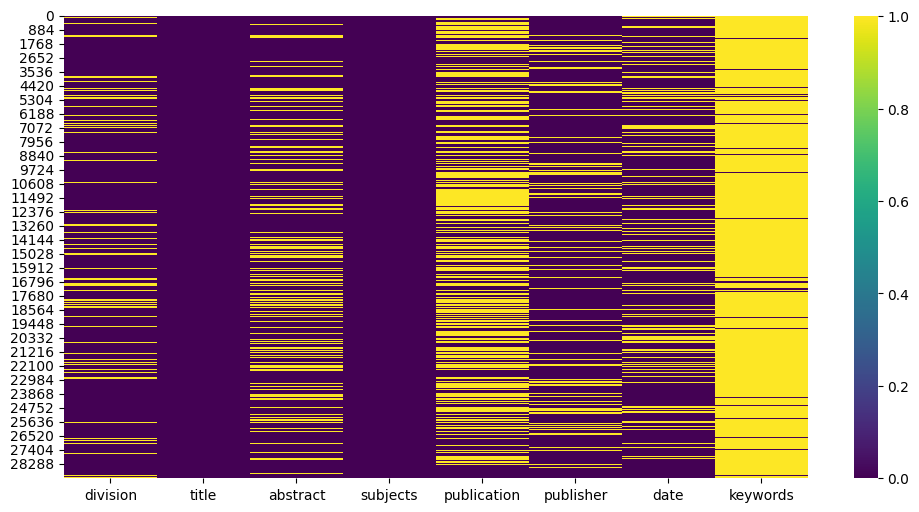

In [ ]:
# Menampilkan visualisasi dari missing data
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=True, cmap='viridis')
plt.show()

## Mengisi *missing values* dalam kolom 'abstract' dengan string kosong (' ')

In [ ]:
df['abstract'].fillna('', inplace=True)

In [ ]:
# menampilkan nilai missing data pada kolom abstrak yang menjadi 0
df.isna().sum()

division        3943
title              0
abstract           0
subjects          95
publication    14099
publisher       5729
date            6361
keywords       27131
dtype: int64

# 2. Memisahkan Keyword dan Memindahkannya ke kolom 'Keyword'

In [ ]:
# Fungsi get_keyword untuk mengekstrak keywords dari teks menggunakan regular expression
def get_keyword(text):
  # Cari Pola Regex Keyword pada abstract
  result = re.search(r'Keyword[s]?:( \w+[,]*)+', text)

  if result:
    # Hilangkan kata-kata "Keyword" dari hasil pencarian
    result = re.sub(r'Keyword[s]?: ', '', result.group(0))
    # Pisahkan keyword berdasarkan tanda koma, dan hapus spasi berlebih
    return [x.strip().lower() for x in result.split(',')]
  else:
    return ['']

- Jika hasil pencarian regex tidak menemukan kata kunci dalam teks, maka fungsi akan mengembalikan daftar berisi satu elemen berisi string kosong [''].

Jadi, fungsi *get_keyword(text)* akan mengembalikan daftar kata kunci yang diambil dari teks yang mengandung kata kunci dalam format "Keyword:" atau "Keywords:" dan mengubahnya menjadi huruf kecil serta menghapus spasi berlebih.

In [ ]:
# Fungsi delete_keyword untuk menghapus frasa-frasa yang mengandung kata kunci (keywords) dari teks.
def delete_keyword(text):
  result = re.sub(r'Keyword[s]?:( \w+[,]*)+', '', text)
  return result

Dalam hal ini, fungsi tersebut menggunakan *modul re* (Regular Expressions) dalam Python untuk menghapus frasa yang cocok dengan pola tertentu dalam teks yang diberikan.

Penjelasan :
1. re.sub() adalah fungsi dalam modul re yang digunakan untuk mengganti frasa yang cocok dengan pola yang diberikan dengan teks pengganti (replacement text).
2. r'Keyword[s]?:( \w+[,]*)+' adalah pola reguler yang akan dicocokkan dalam teks. Mari kita jelaskan bagian-bagian dari pola ini:
3. Keyword[s]?: Ini mencocokkan kata "Keyword" atau "Keywords" dengan s menjadi opsional (dengan tanda tanya ?) yang berarti dapat ada atau tidak ada. Ini mencocokkan kata kunci dalam bentuk tunggal atau jamak.
4. :: Ini mencocokkan karakter titik dua (colon) setelah kata kunci.
5. (\w+[,]*)+: Ini adalah grup yang mencocokkan satu atau lebih kata (menggunakan \w+) yang diikuti oleh koma (,) opsional. Grup ini dapat berulang beberapa kali dengan +, sehingga mencocokkan satu atau lebih kata diikuti oleh koma.
6. '' adalah teks pengganti yang digunakan untuk mengganti frasa yang cocok dengan pola di atas. Dalam hal ini, frasa yang cocok akan digantikan dengan string kosong, sehingga dihapus dari teks.
7. Hasil dari pemanggilan re.sub() adalah teks yang telah dimodifikasi.

Jadi, fungsi delete_keyword(text) akan menghapus semua frasa yang mengandung kata kunci (dengan format "Keyword:" atau "Keywords:") dari teks yang diberikan dan mengembalikan teks yang telah dimodifikasi tanpa frasa-frasa tersebut.

In [ ]:
df['keywords'] = df['abstract'].apply(lambda x: get_keyword(x))
df['abstract'] = df['abstract'].apply(lambda x: delete_keyword(x))

In [ ]:
df.isna().sum()

division        3943
title              0
abstract           0
subjects          95
publication    14099
publisher       5729
date            6361
keywords           0
dtype: int64

In [ ]:
# Membuat dataframe baru yang terdapat keyword yang telah di preprocessing
df_keywords = df
df.to_csv('/content/drive/MyDrive/RISET STKI/Preprocessing/1. Keywords/df_with_keyword.csv')

# 3. Raw Fulltext

In [ ]:
df_keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29162 entries, 0 to 29161
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   division     25219 non-null  object
 1   title        29162 non-null  object
 2   abstract     29162 non-null  object
 3   subjects     29067 non-null  object
 4   publication  15063 non-null  object
 5   publisher    23433 non-null  object
 6   date         22801 non-null  object
 7   keywords     29162 non-null  object
dtypes: object(8)
memory usage: 1.8+ MB


In [ ]:
def createRawFulltext(data):
  return data['title'] + ' ' + data['abstract'] + ' ' + ' '.join(data['keywords'])

data['title'] + ' ' + data['abstract'] + ' '.join(data['keywords']): Ini adalah ekspresi yang menggabungkan tiga bagian yaitu judul, teks abstrak, dan kata kunci, menjadi satu string tunggal dengan spasi sebagai pemisah.

In [ ]:
df_keywords['fulltext_raw'] = df_keywords.apply(lambda x: createRawFulltext(x), axis=1)

In [ ]:
df_keywords.iloc[0]['fulltext_raw']

'Identifikasi Kontaminasi Bakteri \r\nColiform\r\nPada Daging Sapi Segar Yang Dijual \r\nDi Pasar Sekitar Kota Bandar Lampung Abstrak\r\nColiform\r\nmerupakan  bakteri  yang  memiki  habitat  normal  di  usus  manusia  dan  juga  hewan.  Oleh \r\nkarena  itu  bakteri \r\nColiform\r\n,  terutama \r\nEscherichia  coli,\r\nmenjadi  indikasi  d\r\nari  kontaminasi  fekal \r\npada air minum maupun makanan. Penyebaran \r\nColiform\r\ndari manusia ke manusia yang lain dapat \r\nterjadi melalui jalur fekal oral yaitu dengan cara  manusia memakan makanan atau minuman yang \r\ntelah  terkontaminasi  feses  manusia.  Infeksi \r\nColifo\r\nrm\r\npada  manusia  seringkali  disebabkan  oleh \r\nkonsumsi  makanan  produk  hewan  yang  tercemar,  misalnya  daging  dan  susu.  Penelitian  ini \r\ndilakukan  untuk  untuk  mengetahui  kontaminasi \r\nColiform\r\npada  daging  sapi  segar  yang  dijual  di \r\npasar  di  sekitar  kota  Bandar  Lampun\r\ng.\r\nPenelitian  deteksi  bakteri \r\nColiform\r\nd

In [ ]:
# Membuat file csv data raw
df_raw_full = df_keywords
df_raw_full.to_csv('/content/drive/MyDrive/RISET STKI/Preprocessing/2. Fulltext Raw/raw_data.csv')

# 4. Detect Language

In [ ]:
def detect_language(text):
  try:
    src_lang = detect(text)
  except:
    src_lang = '?'
  return src_lang

jika fungsi *detect_language(text)* berhasil mendeteksi bahasa teks, maka kode bahasa tersebut akan diambil sebagai hasil. Namun, jika terjadi kesalahan saat mendeteksi bahasa, maka fungsi akan mengembalikan tanda tanya ('?') sebagai nilai yang menunjukkan bahwa deteksi bahasa tidak berhasil.

Membuat kolom baru dengan nama *'lang'* dalam DataFrame *'df_raw_full'* yang akan berisi hasil dari deteksi bahasa (language detection) untuk setiap teks dalam kolom *'fulltext_raw'*. Kode ini menggunakan *metode .apply()* dengan fungsi lambda untuk menerapkan fungsi detect_language(x) pada setiap teks dalam kolom 'fulltext_raw'.

In [ ]:
df_raw_full['lang'] = df_raw_full['fulltext_raw'].apply(lambda x : detect_language(x))

In [ ]:
# Membuat csv dari df_raw_full
df_lang = df_raw_full
df_lang.to_csv('/content/drive/MyDrive/RISET STKI/Preprocessing/3. Detect Language/df_language_detected.csv')

In [ ]:
df_id = df_lang[df['lang'] == 'id']
df_other = df_lang[df['lang'] != 'id']

In [ ]:
df_id.to_csv('/content/drive/MyDrive/RISET STKI/Preprocessing/3. Detect Language/idn_language.csv')
df_other.to_csv('/content/drive/MyDrive/RISET STKI/Preprocessing/3. Detect Language/other_language.csv')

# 5. Cleaning
lakukan cleaning text pada Title dan abstract, text hanya alphabetnumerical, hapus whitespace tetapi pertahankan angka dengan whitespace seperti 0,0 0.0, -0, - 0, 0%

In [ ]:
def clean_text(text):
  result = text.lower()
  result = re.sub(r'[^\w\s\.,%\-]+', ' ', result) # Remove Symbol
  result = re.sub(r'[_]+', ' ', result) # Remove Underscore
  result = re.sub(r'([\d]+)[\s]*(%)|([\d]+)[\s]*(-)[\s]*([\d]+)|(-)[\s]*([\d]+)', r'\1\2\3\4\5\6\7', result) # Remove space between digit and symbol (1 - 2, 1 %)
  result = re.sub(r'([\D])[\.,]+', r'\1 ', result) # Remove dot and comma (exceeding)
  result = re.sub(r'[\.,]+([\D])', r'\1 ', result) # Remove dot and comma (preceeding)
  result = re.sub(r'([\D])[%]+', r'\1 ', result) # Remove Percent
  result = re.sub(r'([\D])-+([\D])|-+([\D])', r'\1\2\3 ', result) # Remove Strip
  result = re.sub(r'[\s]+', ' ', result) # Remove Multiple Whitespace
  result = result.strip()
  return result

In [ ]:
df_id['fulltext'] = df_id['fulltext_raw'].apply(lambda x: clean_text(x))

<ipython-input-26-2ef6ea8b500f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id['fulltext'] = df_id['fulltext_raw'].apply(lambda x: clean_text(x))


In [ ]:
df_cleaned = df_id

In [ ]:
df_cleaned.to_csv('/content/drive/MyDrive/RISET STKI/Preprocessing/4. Data Cleaned/data_cleaned.csv')

# 6. Stopword Removal

In [ ]:
def remove_stopword(text):
  factory = StopWordRemoverFactory()
  custom = ['mutlak',
            'era',
            'cenderung',
            'bantu',
            'paham',
            'dimana',
            'harap',
            'bahas',
            'definisi',
            'dimana',
            'dasar',
            'duga',
            'pakai',
            'pilih',
            'sesuai',
            'meliputi',
            'dituliskan',
            'dinyatakan',
            'keberlanjutan',
            'memperoleh',
            'diperoleh',
            'diharapkan',
            'mengharapkan',
            'berharap',
            'membahas',
            'dibahas',
            'didefinisikan',
            'mendefinisikan',
            'didalam',
            'kedalam',
            'memiliki',
            'dimiliki',
            'berdasarkan',
            'didasari',
            'berlandaskan',
            'diduga',
            'menduga',
            'menggambarkan',
            'digambarkan',
            'memakai',
            'dipakai',
            'memilih',
            'dipilih',
            'disesuaikan',
            'menyesuaikan',
            'kesesuaian',
            'diliputi',
            'menjabarkan',
            'dijabarkan',
            'penjabaran']
  stopwords = factory.get_stop_words()
  stopwords.extend(custom)

  result = []
  for x in  text.split():
    if x not in stopwords:
      result.append(x)

  return " ".join(result)

In [ ]:
df_cleaned['fulltext_clean'] = df_cleaned['fulltext'].apply(lambda x: remove_stopword(x))

<ipython-input-30-4bdb99f823fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['fulltext_clean'] = df_cleaned['fulltext'].apply(lambda x: remove_stopword(x))


In [ ]:
df_stopword = df_cleaned
df_stopword.to_csv('/content/drive/MyDrive/RISET STKI/Preprocessing/5. Stopword/df_fulltext_cleaned.csv')

# 7. Stemming
Stemming adalah proses dalam pemrosesan bahasa alami (*natural language processing - NLP*) yang bertujuan untuk mengubah kata-kata dalam teks menjadi kata dasar (root word).

Tujuan dari stemming adalah untuk menghilangkan afiks (imbuhan) dari kata-kata sehingga kata-kata yang berbeda tetapi memiliki akar kata yang sama akan dianggap sebagai satu entitas yang sama.

Stemming adalah teknik yang berguna dalam analisis teks untuk mengurangi variasi kata yang mungkin muncul dalam teks yang sama. Ini membantu dalam pemahaman teks dan dapat digunakan dalam proses seperti klasifikasi teks, pencarian informasi, dan analisis teks sentimen.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/RISET STKI/Preprocessing/5. Stopword/df_fulltext_cleaned.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df.head(5).T

,0,1,2,3,4
division,FK1,NaN,FP3,FP3,FP1
title,Identifikasi Kontaminasi Bakteri \r\nColiform\...,AKTIVITAS IN VITRO DAN STUDI PERBANDINGAN BEBE...,KAJIAN TINGKAT KECERNAAN PAKAN BUATAN YANG BER...,PENGGUNAAN \r\nTEPUNG DAGING DAN TULANG\r\nSEB...,Akreditas Jurnal Ilmu Ilmu Agribisnis 2022
abstract,Abstrak\r\nColiform\r\nmerupakan bakteri yan...,ABSTRAK\r\nTelah dibuat senyawa turunan dibuti...,ABSTRAK\r\nPenelitian\r\ndilakukan untuk men...,ABSTRAK\r\n‡\r\nP\r\nenelitian\r\ndilakukan un...,Merupakan surat keputusan akreditas jurnal yan...
subjects,AC,"AC, AI",AC,AC,AC
publication,Jurnal Kedokteran,J. Sains MIPA,Jurnal Rekayasa dan Teknologi Budidaya Perairan,Jurnal Rekayasa Teknologi dan Budidaya Perairan,NaN
publisher,NaN,NaN,NaN,NaN,"Direktorat Jenderal Perguruan Tinggi, Kementer..."
date,2013-07,2013,2013-02,2013-10,2022-11
keywords,[''],[''],[''],[''],['']
fulltext_raw,Identifikasi Kontaminasi Bakteri \r\nColiform\...,AKTIVITAS IN VITRO DAN STUDI PERBANDINGAN BEBE...,KAJIAN TINGKAT KECERNAAN PAKAN BUATAN YANG BER...,PENGGUNAAN \r\nTEPUNG DAGING DAN TULANG\r\nSEB...,Akreditas Jurnal Ilmu Ilmu Agribisnis 2022 Mer...
lang,id,id,id,id,id


In [ ]:
def stem(text):
  # inisialisasi pustaka Sastrawi dan membuat objek factory untuk stemmer
  factory = StemmerFactory()
  # Stemmer adalah komponen utama dalam proses stemming yang digunakan untuk mengubah kata-kata dalam teks menjadi bentuk dasarnya atau kata dasar.
  stemmer = factory.create_stemmer()
  # hasil return adalah teks yang telah diubah menjadi bentuk kata dasar
  return stemmer.stem(text)

In [ ]:
for i in tqdm(range(9, 10)):
  df_final_other = df.iloc[i*500:(i+1)*500 if (i+1)*500 < df.shape[0] else df.shape[0]]
  df_final_other['text_stemmed'] = df_final_other['fulltext_clean'].apply(lambda x : stem(x))
  df_final_other.to_csv(f'/content/drive/MyDrive/RISET STKI/Preprocessing/6. Stemming/File Partition/ke-{i+1}.csv')

  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-35-f985960f53f3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_other['text_stemmed'] = df_final_other['fulltext_clean'].apply(lambda x : stem(x))
100%|██████████| 1/1 [14:38<00:00, 878.54s/it]


Perulangan di atas adalah operasi untum membuat DataFrame *'df_final_other' *yang berisi 500 atau lebih baris data (atau sisa data jika kurang dari 500), dan *kolom 'text_stemmed'* yang berisi teks yang telah di-stem sesuai dengan bahasa Indonesia menggunakan pustaka Sastrawi.

# 8. Post-tag Detection
Deteksi POS (*Part-of-Speech*) atau penandaan POS adalah tugas dalam pemrosesan bahasa alami (NLP) yang mengidentifikasi jenis kata atau token dalam sebuah teks dan mengklasifikasikannya ke dalam kategori-kategori berdasarkan peran gramatikal atau tata bahasa dalam kalimat. Setiap kata dalam bahasa memiliki peran gramatikal tertentu yang disebut sebagai POS. Contoh POS meliputi kata kerja, kata benda, kata sifat, kata keterangan, dan lainnya.

In [ ]:
!pip install spacy
#python -m spacy download en_core_web_sm

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/RISET STKI/Preprocessing/6. Stemming/File Partition/ke-10.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head(5).T

,0,1,2,3,4
division,FH3,FK1,FH3,FH3,FH3
title,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,Kekerasan dalam Rumah Tangga pada Kasus Pernik...,Angin Baru Penegakan Hukum di Lampung,Bumi Menangis di Bandar Lampung,Hart's Primary Rules di Lampung Barat
abstract,Perlindungan paten obat khususnya obat dan ata...,Seorang perempuan datang ke rumah sakit umum d...,NaN,NaN,NaN
subjects,K1,K1,"K1, KZ","K1, KZ","K1, KZ"
publication,NaN,Jurnal Medula,Kolom Pakar harian Lampung Post,Kolom Pakar harian Lampung Post,NaN
publisher,http://lppm.unila.ac.id/,NaN,NaN,NaN,Lampost Publishing
date,2021,2016-12,NaN,NaN,NaN
keywords,[''],[''],[''],[''],['']
fulltext_raw,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,Kekerasan dalam Rumah Tangga pada Kasus Pernik...,Angin Baru Penegakan Hukum di Lampung,Bumi Menangis di Bandar Lampung,Hart's Primary Rules di Lampung Barat
lang,id,id,id,id,id


In [ ]:
# Buat list untuk menyimpan hasil deteksi POS
pos_tags_list = []

In [ ]:
# Loop melalui teks dalam kolom 'fulltext_clean'
for text in df['fulltext_clean']:
    # Proses teks dengan spaCy
    doc = nlp(text)

    # Lakukan deteksi POS dan tambahkan ke list
    pos_tags = [(token.text, token.pos_) for token in doc]
    pos_tags_list.append(pos_tags)

In [ ]:
# Tambahkan kolom baru '_fulltext_clean_postag' ke DataFrame
df['fulltext_clean_postag'] = pos_tags_list

# Simpan DataFrame yang telah diperbarui ke dalam file CSV
df.to_csv('/content/drive/MyDrive/RISET STKI/Preprocessing/7. Post-tag Detection/df_with_pos-tag.csv', index=False)

## 9. Data Augmentation - Synonim
Data Augmentation adalah teknik yang digunakan dalam pemrosesan citra dan pemrosesan bahasa alami (NLP) untuk menghasilkan variasi data yang lebih banyak dari data yang sudah ada. Tujuan utama dari data augmentation adalah untuk meningkatkan kualitas dan jumlah data pelatihan yang tersedia untuk model pembelajaran mesin, terutama dalam tugas-tugas seperti klasifikasi, deteksi objek, dan pemrosesan teks.

Data augmentation adalah alat yang berguna dalam mengatasi masalah kurangnya data pelatihan dalam pembelajaran mesin, terutama dalam tugas-tugas yang kompleks dan beragam. Dengan menghasilkan variasi data yang lebih banyak, model pembelajaran mesin dapat menjadi lebih kuat dan dapat menggeneralisasi lebih baik pada data baru.

In [81]:
import nltk
import requests
import json
import random
from nltk.corpus import wordnet

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Menginstal ibrary NLTK (*Natural Language Toolkit*) dan ***WordNet***, yang merupakan sumber daya linguistik yang berguna untuk pemrosesan bahasa alami.



*   NLTK adalah library Python yang sering digunakan dalam pemrosesan bahasa alami (NLP) untuk tugas seperti tokenisasi, analisis sintaksis, dan pencarian informasi dalam teks.
*   ***random*** adalah library Python yang memungkinkan untuk melakukan operasi acak. Kita akan menggunakan library ini untuk memilih satu sinonim secara acak jika ada beberapa sinonim yang tersedia.

In [80]:
df = pd.read_csv('/content/drive/MyDrive/RISET STKI/Preprocessing/7. Post-tag Detection/df_with_pos-tag.csv')
df.head(5).T

,0,1,2,3,4
division,FH3,FK1,FH3,FH3,FH3
title,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,Kekerasan dalam Rumah Tangga pada Kasus Pernik...,Angin Baru Penegakan Hukum di Lampung,Bumi Menangis di Bandar Lampung,Hart's Primary Rules di Lampung Barat
abstract,Perlindungan paten obat khususnya obat dan ata...,Seorang perempuan datang ke rumah sakit umum d...,NaN,NaN,NaN
subjects,K1,K1,"K1, KZ","K1, KZ","K1, KZ"
publication,NaN,Jurnal Medula,Kolom Pakar harian Lampung Post,Kolom Pakar harian Lampung Post,NaN
publisher,http://lppm.unila.ac.id/,NaN,NaN,NaN,Lampost Publishing
date,2021,2016-12,NaN,NaN,NaN
keywords,[''],[''],[''],[''],['']
fulltext_raw,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,Kekerasan dalam Rumah Tangga pada Kasus Pernik...,Angin Baru Penegakan Hukum di Lampung,Bumi Menangis di Bandar Lampung,Hart's Primary Rules di Lampung Barat
lang,id,id,id,id,id


In [76]:
# Fungsi untuk mencari sinonim kata
# def get_synonyms(word):
#     synonyms = []
#     for syn in wordnet.synsets(word): # untuk mencari semua kelompok kata (synsets) yang mengandung kata tersebut. WordNet mengelompokkan kata-kata berdasarkan makna dan penggunaannya yang berbeda.
#         for lemma in syn.lemmas(): # untuk mendapatkan daftar kata dasar yang terkait dengan kelompok kata tersebut.
#             synonyms.append(lemma.name()) # menambahkan lemma-lemma tersebut ke dalam daftar synonyms
#     return list(set(synonyms))

f = requests.get('https://raw.githubusercontent.com/victoriasovereigne/tesaurus/master/dict.json')
data = json.loads(f.text)

In [77]:
# Fungsi untuk mengganti kata-kata dengan sinonim
# def replace_with_synonyms(text):
#     words = nltk.word_tokenize(text)
#     new_words = []
#     for word in words:
#         synonyms = get_synonyms(word)
#         if synonyms:
#             new_word = random.choice(synonyms)
#             new_words.append(new_word)
#         else:
#             new_words.append(word)
#     return ' '.join(new_words)

def replace_text(text):
  result = []
  text_token = text.split(' ')
  for i in range(len(text_token)):
    if text_token[i] in data.keys():
      for sinonim in data[text_token[i]]['sinonim']:
        temp = text_token.copy()
        temp[i] = sinonim
        result.append(' '.join(temp))

  return result

* Fungsi ***replace_text(text)*** bertujuan untuk menggantikan kata-kata dalam
teks dengan sinonim-sinonim yang terkait dengan kata-kata tersebut, berdasarkan dictionary yang telah diunduh yang ada di file JSON.

* Fungsi ***replace_text*** menghasilkan daftar teks yang merupakan variasi dari teks input awal, di mana beberapa kata telah digantikan dengan sinonim-sinonim yang sesuai dari data sinonim yang diunduh (File JSON).

In [78]:
def augment_synonim(data):
  result = pd.DataFrame()

  for i in replace_text(data['fulltext_clean']):
    temp_df = pd.DataFrame(data).T
    temp_df['fulltext_clean_synonim'] = i
    result = pd.concat([result, temp_df], ignore_index=True)

    temp_df

  return result

Fungsi ***augment_synonim(data)*** bertujuan untuk melakukan augmentasi data dengan mengganti kata-kata dalam kolom ***fulltext_clean*** dengan sinonim-sinonimnya dan menghasilkan DataFrame yang berisi variasi teks yang telah dimodifikasi dan di simpan di ***temp_df***.

In [ ]:
df_augment = pd.DataFrame()
for i in tqdm(range(len(df))):
  df_augment = pd.concat([df_augment, augment_synonim(df.iloc[i])], ignore_index=True)

df_augment.T

100%|██████████| 500/500 [06:20<00:00,  1.31it/s]


,0,1,2,3,4,5,6,7,8,9,...,282272,282273,282274,282275,282276,282277,282278,282279,282280,282281
division,FH3,FH3,FH3,FH3,FH3,FH3,FH3,FH3,FH3,FH3,...,FH2,FH2,FH2,FH2,FH2,FH2,FH2,FH2,FH2,FH2
title,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,...,Pengakuan Masyarakat Hukum Adat,Pengakuan Masyarakat Hukum Adat,Pengakuan Masyarakat Hukum Adat,Pengakuan Masyarakat Hukum Adat,Pengakuan Masyarakat Hukum Adat,Pengakuan Masyarakat Hukum Adat,Pengakuan Masyarakat Hukum Adat,Pengakuan Masyarakat Hukum Adat,Pengakuan Masyarakat Hukum Adat,Pengakuan Masyarakat Hukum Adat
abstract,Perlindungan paten obat khususnya obat dan ata...,Perlindungan paten obat khususnya obat dan ata...,Perlindungan paten obat khususnya obat dan ata...,Perlindungan paten obat khususnya obat dan ata...,Perlindungan paten obat khususnya obat dan ata...,Perlindungan paten obat khususnya obat dan ata...,Perlindungan paten obat khususnya obat dan ata...,Perlindungan paten obat khususnya obat dan ata...,Perlindungan paten obat khususnya obat dan ata...,Perlindungan paten obat khususnya obat dan ata...,...,Pengakuan dan perlindungan konstitusional terh...,Pengakuan dan perlindungan konstitusional terh...,Pengakuan dan perlindungan konstitusional terh...,Pengakuan dan perlindungan konstitusional terh...,Pengakuan dan perlindungan konstitusional terh...,Pengakuan dan perlindungan konstitusional terh...,Pengakuan dan perlindungan konstitusional terh...,Pengakuan dan perlindungan konstitusional terh...,Pengakuan dan perlindungan konstitusional terh...,Pengakuan dan perlindungan konstitusional terh...
subjects,K1,K1,K1,K1,K1,K1,K1,K1,K1,K1,...,K1,K1,K1,K1,K1,K1,K1,K1,K1,K1
publication,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
publisher,http://lppm.unila.ac.id/,http://lppm.unila.ac.id/,http://lppm.unila.ac.id/,http://lppm.unila.ac.id/,http://lppm.unila.ac.id/,http://lppm.unila.ac.id/,http://lppm.unila.ac.id/,http://lppm.unila.ac.id/,http://lppm.unila.ac.id/,http://lppm.unila.ac.id/,...,---,---,---,---,---,---,---,---,---,---
date,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,...,2018-07-26,2018-07-26,2018-07-26,2018-07-26,2018-07-26,2018-07-26,2018-07-26,2018-07-26,2018-07-26,2018-07-26
keywords,[''],[''],[''],[''],[''],[''],[''],[''],[''],[''],...,[''],[''],[''],[''],[''],[''],[''],[''],[''],['']
fulltext_raw,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,...,Pengakuan Masyarakat Hukum Adat Pengakuan dan ...,Pengakuan Masyarakat Hukum Adat Pengakuan dan ...,Pengakuan Masyarakat Hukum Adat Pengakuan dan ...,Pengakuan Masyarakat Hukum Adat Pengakuan dan ...,Pengakuan Masyarakat Hukum Adat Pengakuan dan ...,Pengakuan Masyarakat Hukum Adat Pengakuan dan ...,Pengakuan Masyarakat Hukum Adat Pengakuan dan ...,Pengakuan Masyarakat Hukum Adat Pengakuan dan ...,Pengakuan Masyarakat Hukum Adat Pengakuan dan ...,Pengakuan Masyarakat Hukum Adat Pengakuan dan ...
lang,id,id,id,id,id,id,id,id,id,id,...,id,id,id,id,id,id,id,id,id,id


***df_augment*** adalah DataFrame yang lebih besar yang berisi berbagai variasi teks yang telah dimodifikasi dengan menggunakan sinonim-sinonim dari DataFrame  df. Hasil augmentasi dari setiap iterasi menjadi digabungkan menjadi satu yaitu, ***df_augment***.

In [ ]:
# Simpan DataFrame yang telah diperbarui ke dalam file CSV
df_augment.to_csv('/content/drive/MyDrive/RISET STKI/Preprocessing/8. Data Augmentation/synonims.csv', index=False)

# 10. Data Augmentation - Random Deletion

***Data Augmentation - Random Deletion*** adalah salah satu teknik augmentasi data dalam pemrosesan bahasa alami (NLP) yang digunakan untuk meningkatkan variasi dalam data pelatihan dengan cara menghapus secara acak sebagian kata-kata dari teks.

Hasil dari proses ini adalah variasi teks yang masih memiliki makna tetapi dengan beberapa kata yang dihapus secara acak.

Contoh:

* Teks awal : "Ini adalah contoh teks yang panjang."
* Hasil Augmentation Random Deletion : "Ini adalah teks yang panjang."

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
def delete_random(word):
  token = word_tokenize(word)
  random_element = random.choice(token)
  token.remove(random_element)

  return ' '.join(token)

In [ ]:
df_augment_random = df_augment
df_augment_random['fulltext_clean_augment_deletion'] = df_augment_random['fulltext_clean'].apply(lambda x: delete_random(x))
df_augment_random.head(5).T

,0,1,2,3,4
division,FH3,FH3,FH3,FH3,FH3
title,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...
abstract,Perlindungan paten obat khususnya obat dan ata...,Perlindungan paten obat khususnya obat dan ata...,Perlindungan paten obat khususnya obat dan ata...,Perlindungan paten obat khususnya obat dan ata...,Perlindungan paten obat khususnya obat dan ata...
subjects,K1,K1,K1,K1,K1
publication,NaN,NaN,NaN,NaN,NaN
publisher,http://lppm.unila.ac.id/,http://lppm.unila.ac.id/,http://lppm.unila.ac.id/,http://lppm.unila.ac.id/,http://lppm.unila.ac.id/
date,2021,2021,2021,2021,2021
keywords,[''],[''],[''],[''],['']
fulltext_raw,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...,KEPENTINGAN UMUM DALAM PEMBERIAN PATEN OBATDI ...
lang,id,id,id,id,id


In [ ]:
df_augment_random.to_csv('/content/drive/MyDrive/RISET STKI/Preprocessing/8. Data Augmentation/random_deletion.csv')